# Adding SE values to the human labels file

**run once**

In [ ]:
import json

def update_with_semantic_entropy():
    with open('human_sample_xor_tydiqa.json', 'r', encoding='utf-8') as f:
        human_sample = json.load(f)
    with open('semantic_entropy_Llama3.1-8b_xor_tydiqa_results.json', 'r', encoding='utf-8') as f:
        semantic_entropy_data = json.load(f)

    # Create a mapping of questions to their semantic entropy data
    question_to_entropy = {}
    for key, data in semantic_entropy_data.items():
        question = data.get('question')
        if question:
            question_to_entropy[question] = {
                'semantic_entropy': data.get('semantic_entropy'),
                'num_clusters': data.get('num_clusters'),
                'cluster_probabilities': data.get('cluster_probabilities')
            }

    # Update
    updated_count = 0
    for key, data in human_sample.items():
        question = data.get('question')
        if question and question in question_to_entropy:
            # Add semantic entropy data to the human sample
            entropy_data = question_to_entropy[question]
            data['semantic_entropy'] = entropy_data['semantic_entropy']
            updated_count += 1

    # Save the updated human sample
    with open('human_sample_xor_tydiqa_updated.json', 'w', encoding='utf-8') as f:
        json.dump(human_sample, f, ensure_ascii=False, indent=2)

    print(f"Updated {updated_count} questions with semantic entropy data")
    print(f"Saved to human_sample_xor_tydiqa_updated.json")

update_with_semantic_entropy()

Updated 100 questions with semantic entropy data
Saved to human_sample_xor_tydiqa_updated.json


# AUROC
To determine a threshold (on sample!)

Class distribution:
  Hallucinated: 81 (81.0%)
  Non-hallucinated: 19 (19.0%)

Average entropy for hallucinated samples: 0.1741160036750387
Average entropy for non-hallucinated samples: 0.1077389036351398

AUROC Score (entropy-sample): 0.6965562053281351

Optimal threshold: 4.823808738703801e-07
TPR - FPR = 0.471 TPR= 0.840 FPR = 0.368

Performance at optimal threshold:
Accuracy: 0.8000
Precision: 0.9067
Recall: 0.8395
F1 Score: 0.8718

Confusion Matrix:
TN: 12, FP: 7
FN: 13, TP: 68


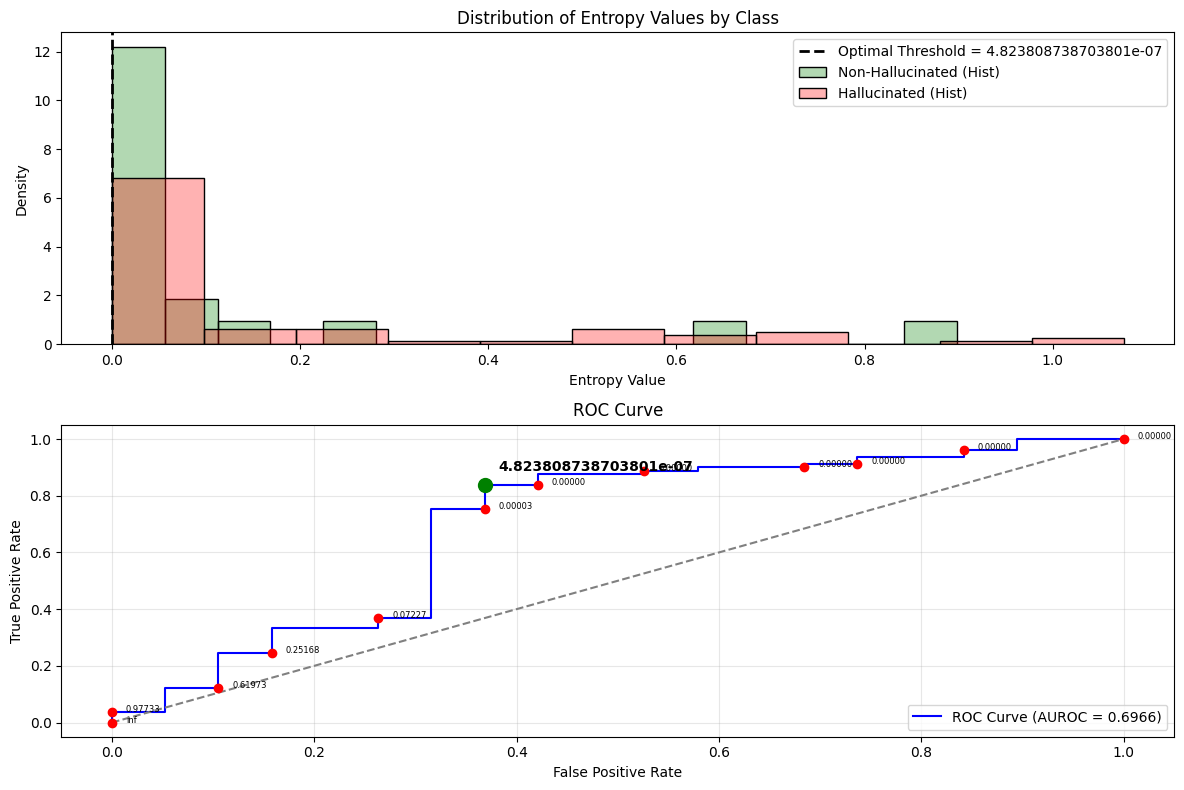

In [35]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import math

# Load the data
with open("human_sample_xor_tydiqa.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract ground truth labels and semantic entropy values
true_labels = []
semantic_entropy_values = []
question_ids = []
for question_id, question_data in data.items():
    # Convert labels to num (1 hallucinated, 0 non-hallucinated)
    true_label = 1 if question_data.get("question_label") == "Hallucinated" else 0
    # Save ground truth, entropy values, and question IDs
    true_labels.append(true_label)
    semantic_entropy_values.append(question_data.get("semantic_entropy"))
    question_ids.append(question_id)

true_labels = np.array(true_labels)
semantic_entropy_values = np.array(semantic_entropy_values)
question_ids = np.array(question_ids)

# Print class distribution
hallucinated_count = np.sum(true_labels == 1)
non_hallucinated_count = np.sum(true_labels == 0)
print(f"Class distribution:")
print(f"  Hallucinated: {hallucinated_count} ({hallucinated_count/len(true_labels)*100:.1f}%)")
print(f"  Non-hallucinated: {non_hallucinated_count} ({non_hallucinated_count/len(true_labels)*100:.1f}%)")

# Check relationship between entropy and hallucination
avg_entropy_hallucinated = np.mean(semantic_entropy_values[true_labels == 1])
avg_entropy_non_hallucinated = np.mean(semantic_entropy_values[true_labels == 0])
print(f"\nAverage entropy for hallucinated samples: {avg_entropy_hallucinated}")
print(f"Average entropy for non-hallucinated samples: {avg_entropy_non_hallucinated}")

# Compute AUROC score for entropy values
auroc = roc_auc_score(true_labels, semantic_entropy_values)
print(f"\nAUROC Score (entropy-sample): {auroc}")

# Plot ROC Curve for the selected entropy values with labeled thresholds
fpr, tpr, thresholds = roc_curve(true_labels, semantic_entropy_values)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal threshold: {optimal_threshold}")
print(f"TPR - FPR = {(tpr[optimal_idx] - fpr[optimal_idx]):.3f} TPR= {(tpr[optimal_idx]):.3f} FPR = {fpr[optimal_idx]:.3f}")  # Best Value: 1 (perfect classifier: TPR=1, FPR=0), 0 is random guessing
# The difference at the threshold is 0.47, which means the model is better at

plt.figure(figsize=(12, 8))

# Histogram of entropy by class
plt.subplot(2, 1, 1)

# Non-Hallucinated
sns.histplot(semantic_entropy_values[true_labels == 0],
             label="Non-Hallucinated (Hist)", color="green",
             kde=False, stat="density", alpha=0.3)
# Hallucinated
sns.histplot(semantic_entropy_values[true_labels == 1],
             label="Hallucinated (Hist)", color="red",
             kde=False, stat="density", alpha=0.3)

# Threshold line
plt.axvline(optimal_threshold, color='black', linestyle='dashed',
            linewidth=2, label=f"Optimal Threshold = {optimal_threshold}")

plt.title("Distribution of Entropy Values by Class")
plt.xlabel("Entropy Value")
plt.ylabel("Density")
plt.legend()

# Create ROC curve
plt.subplot(2, 1, 2)
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUROC = {auroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line

num_thresholds = len(thresholds)
threshold_positions = np.linspace(0, num_thresholds-1, 12).astype(int)

# Plot threshold points and add labels
for idx in threshold_positions:
    plt.plot(fpr[idx], tpr[idx], 'ro')
    plt.annotate(f"{thresholds[idx]:.5f}",
                (fpr[idx], tpr[idx]),
                textcoords="offset points",
                xytext=(10, 0),
                ha='left',
                fontsize=6)

# Highlight the optimal threshold
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'go', markersize=10)
plt.annotate(f"{optimal_threshold}",
            (fpr[optimal_idx], tpr[optimal_idx]),
            textcoords="offset points",
            xytext=(10, 10),
            ha='left',
            fontweight='bold')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("entropy_threshold_analysis_without_normalization.png", dpi=300)

# Calculate metrics for the optimal threshold
predictions = (semantic_entropy_values >= optimal_threshold).astype(int)
true_positive = np.sum((predictions == 1) & (true_labels == 1))
true_negative = np.sum((predictions == 0) & (true_labels == 0))
false_positive = np.sum((predictions == 1) & (true_labels == 0))
false_negative = np.sum((predictions == 0) & (true_labels == 1))

accuracy = (true_positive + true_negative) / len(true_labels)
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\nPerformance at optimal threshold:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix:")
print(f"TN: {true_negative}, FP: {false_positive}")
print(f"FN: {false_negative}, TP: {true_positive}")

# might delete cause i dont need another representation of the sample

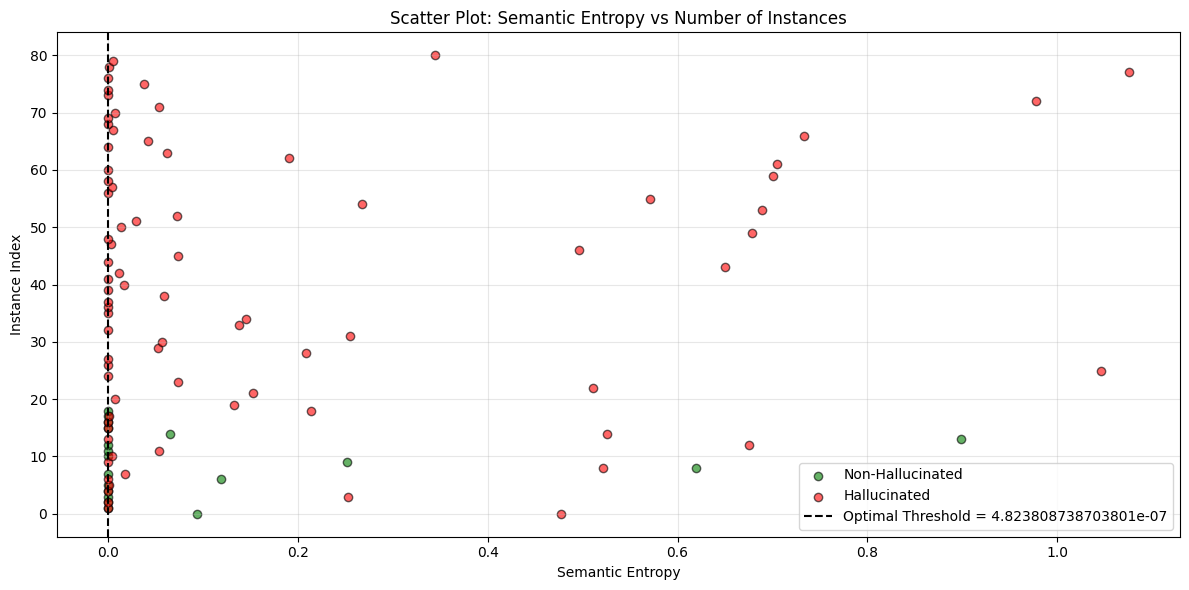

In [ ]:
import matplotlib.pyplot as plt

# Separate entropy values by class
entropy_hallucinated = semantic_entropy_values[true_labels == 1]
entropy_non_hallucinated = semantic_entropy_values[true_labels == 0]

# Create y-values (just for visual spreading)
y_hallucinated = np.arange(len(entropy_hallucinated))
y_non_hallucinated = np.arange(len(entropy_non_hallucinated))

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(entropy_non_hallucinated, y_non_hallucinated,
            color='green', alpha=0.6, label="Non-Hallucinated", edgecolor='k')
plt.scatter(entropy_hallucinated, y_hallucinated,
            color='red', alpha=0.6, label="Hallucinated", edgecolor='k')

# Optional: vertical threshold line
plt.axvline(optimal_threshold, color='black', linestyle='--', linewidth=1.5,
            label=f"Optimal Threshold = {optimal_threshold}")

plt.xlabel("Semantic Entropy")
plt.ylabel("Instance Index")
plt.title("Scatter Plot: Semantic Entropy vs Number of Instances")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("entropy_vs_instances_scatter.png", dpi=300)
plt.show()

In [ ]:
#get a file with semantic entropy based labels (the sample)
#adding label to each question based on optimal threshold
for i, question_id in enumerate(question_ids):
    entropy = semantic_entropy_values[i]
    predicted_label = "Hallucinated" if entropy >= optimal_threshold else "Non-Hallucinated"
    data[question_id]["question_label_SE"] = predicted_label

# Save the updated data to a new file
with open("human_SE_sample_xor_tydiqa.json", "w", encoding="utf-8") as f_out:
    json.dump(data, f_out, indent=2, ensure_ascii=False)

print(f"\nUpdated file saved as 'human_SE_sample_xor_tydiqa.json'")


Updated file saved as 'human_SE_sample_xor_tydiqa.json'


# labeling the full data based on achieved threshold


In [ ]:
fullDataFile="/content/semantic_entropy_Llama3.1-8b_xor_tydiqa_results.json"
with open(fullDataFile, "r", encoding="utf-8") as f:
    data = json.load(f)

# Add a label based on semantic entropy
for qid, info in data.items():
    entropy = info.get("semantic_entropy", 0)
    label = "Hallucinated" if entropy >= optimal_threshold else "Non-Hallucinated" #optimal threshold here is 4.82e-07
    info["SE_question_label"] = label

# Save to a new file
with open("labeled_data_XORfull_SE.json", "w", encoding="utf-8") as f_out:
    json.dump(data, f_out, indent=2, ensure_ascii=False)

print("File with labels saved as 'labeled_data_XORfull_SE.json'")


File with labels saved as 'labeled_data_XORfull_SE.json'


# comparing RougeL and SE labels

Label distribution in ground truth (RougeL): {'Hallucinated': 677, 'Non-Hallucinated': 31}
Label distribution in predictions (SE): {'Hallucinated': 525, 'Non-Hallucinated': 183}

Classification Metrics:
Accuracy: 0.7345
Precision: 0.9657
Recall: 0.7489
F1 Score: 0.8436
AUROC: 0.5841

Confusion Matrix Statistics:
True Positives (TP): 507
False Positives (FP): 18
True Negatives (TN): 13
False Negatives (FN): 170
Confusion matrix saved as 'confusion_matrix.png'


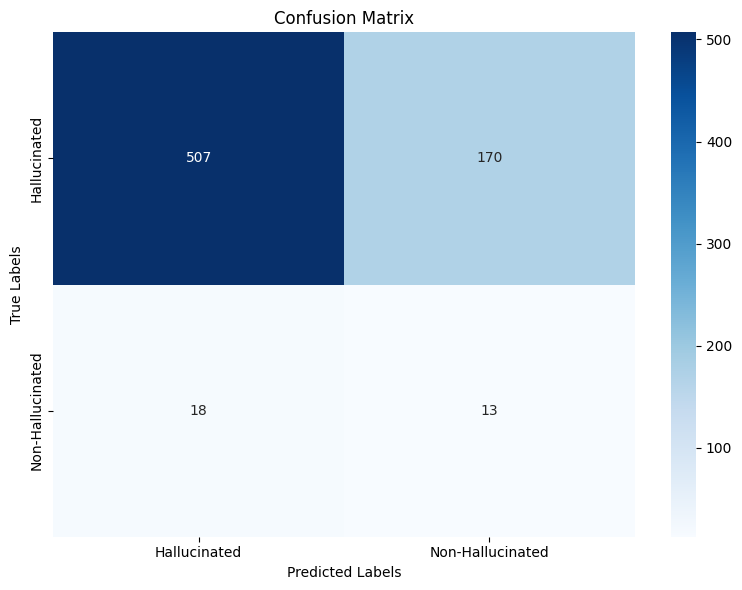

ROC curve saved as 'roc_curve.png'


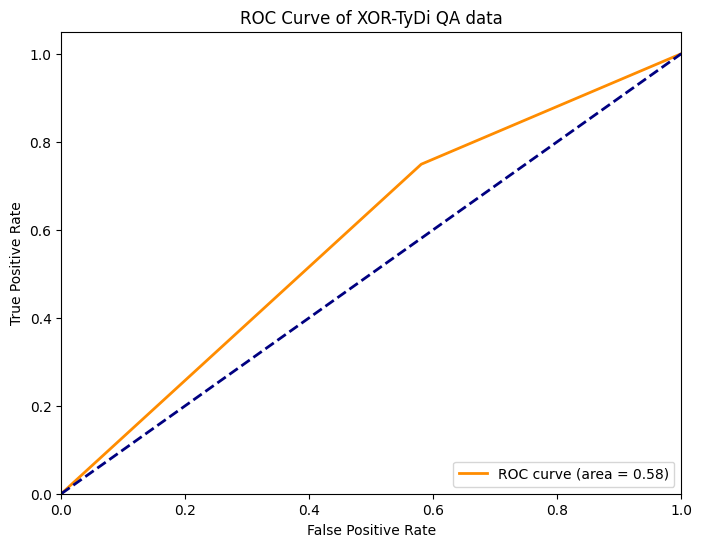

In [52]:
import json
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def calculate_metrics(ground_truth_file, prediction_file):
    ground_truth_data = load_json_file(ground_truth_file)
    prediction_data = load_json_file(prediction_file)

    y_true = []
    y_pred = []

    #for AUROC calculation, we need probabilities
    y_scores = []

    #process each question ID that exists in both files
    ids = set(ground_truth_data.keys()).intersection(set(prediction_data.keys()))
    for question_id in ids:
        # Extract the labels
        true_label = ground_truth_data[question_id].get("computed_question_label")
        pred_label = prediction_data[question_id].get("SE_question_label")

        score = 1.0 if pred_label == "Hallucinated" else 0.0

        y_true.append(true_label)
        y_pred.append(pred_label)
        y_scores.append(score)

    # Convert labels to binary format for ROC curve calculation
    y_true_binary = [1 if label == "Hallucinated" else 0 for label in y_true]
    y_pred_binary = [1 if label == "Hallucinated" else 0 for label in y_pred]

    # Print label distribution for analysis
    print(f"Label distribution in ground truth (RougeL): {dict((x, y_true.count(x)) for x in set(y_true))}")
    print(f"Label distribution in predictions (SE): {dict((x, y_pred.count(x)) for x in set(y_pred))}")

    #labels in sorted order (for consistent confusion matrix)
    labels = sorted(list(set(y_true).union(set(y_pred))))

    auroc = roc_auc_score(y_true_binary, y_scores)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, pos_label="Hallucinated", average='binary'),
        "recall": recall_score(y_true, y_pred, pos_label="Hallucinated", average='binary'),
        "f1_score": f1_score(y_true, y_pred, pos_label="Hallucinated", average='binary'),
        "auroc": auroc,
        "confusion_matrix": confusion_matrix(y_true, y_pred, labels=labels),
        "labels": labels,
        "y_true_binary": y_true_binary,
        "y_scores": y_scores
    }
    return metrics

def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    print("Confusion matrix saved as 'confusion_matrix.png'")
    plt.show()

def plot_roc_curve(y_true_binary, y_scores):
    fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of XOR-TyDi QA data')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    print("ROC curve saved as 'roc_curve.png'")
    plt.show()

def print_confusion_matrix_stats(conf_matrix, labels):
    # Find which index corresponds to the positive class ("Hallucinated")
    pos_index = labels.index("Hallucinated") if "Hallucinated" in labels else 0
    neg_index = 1 - pos_index  # The other index

    tn = conf_matrix[neg_index, neg_index]
    fp = conf_matrix[neg_index, pos_index]
    fn = conf_matrix[pos_index, neg_index]
    tp = conf_matrix[pos_index, pos_index]

    print("\nConfusion Matrix Statistics:")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")

#run
predictions_file = "/content/labeled_data_XORfull_SE.json"  # SE labels file
ground_truth_file = "/content/labeled_data_XORfull_rougel_isri.json"  # RougeL labels file

metrics = calculate_metrics(ground_truth_file, predictions_file)

print("\nClassification Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"AUROC: {metrics['auroc']:.4f}")

# Print and plot confusion matrix
conf_matrix = metrics['confusion_matrix']
labels = metrics['labels']
print_confusion_matrix_stats(conf_matrix, labels)
plot_confusion_matrix(conf_matrix, labels)

plot_roc_curve(metrics['y_true_binary'], metrics['y_scores'])